In [1]:
import torch
from torch_geometric.data import Data
from torch_geometric.transforms import ToUndirected, RemoveIsolatedNodes
from torch_geometric.utils import to_networkx
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn.models import GraphSAGE
import networkx

import os
import json
from bokeh.io import output_notebook, show
from bokeh.models import Range1d, Circle, MultiLine
from bokeh.plotting import figure
from bokeh.plotting import from_networkx
import matplotlib.pyplot as plt
from tqdm import tqdm

from dataset import Dataset

/home/sebastiaan/fun/alarso/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_graph():
    dataset = Dataset()
    dataset.load("data")

    # Add the embeddings to the nodes
    for node in dataset.nodes:
        node[1]["embedding"] = torch.empty((0, 1024))
        if node[0] in os.listdir(f"embeddings/"):
            embedding_paths = [f"embeddings/{node[0]}/{i}" for i in
                               os.listdir(f"embeddings/{node[0]}")]
            for path in embedding_paths:
                with open(path, "r") as f:
                    try:
                        embedding = torch.Tensor(json.load(f))
                        node[1]["embedding"] = torch.cat(
                            (node[1]["embedding"], embedding),
                            dim=0
                        )
                    # Except when the file is empty
                    except json.decoder.JSONDecodeError:
                        pass
        # Take the first 30 embeddings
        node[1]["embedding"] = node[1]["embedding"][:30, :]
        node[1]["embedding"] = torch.nn.ConstantPad2d(
            (0, 0, 30-node[1]["embedding"].shape[0], 0), torch.nan
        )(node[1]["embedding"])
        node[1]["embedding"] = node[1]["embedding"].flatten()

    # Remove edges with no ids in the nodes (the data collection was stopped
    # before expansion to these nodes)
    edge_ids = [i[0][0] for i in dataset.edges] + [i[0][1] for i in dataset.edges]
    edge_ids = list(set(edge_ids))
    node_ids = [i[0] for i in dataset.nodes]
    not_in = [i for i in edge_ids if i not in node_ids]
    print("---", len(dataset.edges))
    dataset.edges = [i for i in dataset.edges if i[0][1] not in not_in]
    print("---", len(dataset.edges))

    # Remove nodes with no embeddings and reconnect their neighbours
    for node in dataset.nodes:
        if node[1]["embedding"].isnan().all():
            node_id = node[0]
            from_edges = [i for i in dataset.edges if i[0][0] == node_id]
            to_edges = [i for i in dataset.edges if i[0][1] == node_id]
            # If there are other nodes that indirectly go through this node
            if len(from_edges) > 0 and len(to_edges) > 0:
                # Connect the nodes here
                from_ids = [i[0][1] for i in from_edges]
                to_ids = [i[0][0] for i in to_edges]
                for from_id in from_ids:
                    for to_id in to_ids:
                        dataset.edges.append([[from_id, to_id],
                                              {"type": "indirect_collaboration"}])
            dataset.edges = [i for i in dataset.edges if i[0][0] != node_id]
            dataset.edges = [i for i in dataset.edges if i[0][1] != node_id]
            dataset.nodes = [i for i in dataset.nodes if i[0] != node_id]

    # Change the idx of the album nodes
    id_map = {}
    for idx, node in enumerate(dataset.nodes):
        id_map[node[0]] = idx
        node[0] = idx

    # And change their indices in the album_artist_edges as well
    for edge in dataset.edges:
        edge[0][0] = id_map[edge[0][0]]
        edge[0][1] = id_map[edge[0][1]]

    # Add y
    for node in dataset.nodes:
        node[1]["y"] = 1 if "hop" in "".join(node[1]["genres"]).lower() else 0

    x = torch.vstack([i[1]["embedding"] for i in dataset.nodes])
    y = torch.tensor([i[1]["y"] for i in dataset.nodes])
    edges = torch.Tensor([[i[0][0], i[0][1]] for i in dataset.edges])
    edges = edges.t().contiguous().long()
    data = Data(x=x, edge_index=edges, y=y)
    data = ToUndirected()(data)
    data = RemoveIsolatedNodes()(data)
    return data, dataset

graph, dataset = load_graph()
 
print(">>> num_nodes:", graph.num_nodes)
print(">>> num_edges:", graph.num_edges)
graph.validate()


--- 616
--- 541
>>> num_nodes: 332
>>> num_edges: 816


True

In [3]:
from bokeh.transform import linear_cmap
from networkx import set_node_attributes
color_by_this_attribute = "y"
color_palette = ["#1f77b4", "#ff7f0e"]
minimum_value_color = 0
maximum_value_color = 1
G = to_networkx(graph)
set_node_attributes(G, {i[0]: i[1][color_by_this_attribute] for i in dataset.nodes}, name=color_by_this_attribute)
plot = figure(tools="pan,wheel_zoom,save,reset", active_scroll='wheel_zoom',
              x_range=Range1d(-10.1, 10.1), y_range=Range1d(-10.1, 10.1), width=800)
network_graph = from_networkx(G, networkx.spring_layout, scale=10, center=(0, 0))
network_graph.node_renderer.glyph = Circle(size=10, #fill_color='skyblue',
                                           fill_alpha=0.8, line_width=0.7,
                                           line_color="black",
                                           fill_color=linear_cmap(color_by_this_attribute, color_palette, minimum_value_color, maximum_value_color))
network_graph.edge_renderer.glyph = MultiLine(line_alpha=0.3, line_width=1)
plot.renderers.append(network_graph)
output_notebook(hide_banner=True)
show(plot)

In [4]:
# in_channels: the size of each input
# hidden_channels: the size of each hidden sample
# num_layers: the number of message passing layers
# out_channels: the size of each output sample (embedding)

from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.sampler import NegativeSampling

model = GraphSAGE(in_channels=-1, hidden_channels=1000, num_layers=5,
                  out_channels=None, dropout=0, act="relu", normalize=True).cuda()
negative_sampler = NegativeSampling(mode="binary", amount=1)
sampler = LinkNeighborLoader(graph, num_neighbors=[20, 10], batch_size=256,
                             replace=True, disjoint=False,
                             neg_sampling=negative_sampler,
                             edge_label_index=graph.edge_index)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
loss_history = []
model.train()
for batch in tqdm(range(1)):
    for sample in iter(sampler):
        # For each node, replicate the embedding until there are 30
        # (so if we did not collect 30 song embeddings, oversample)
        new_x = torch.empty(0, 30*1024).cuda()
        for emb in sample["x"]: 
            emb = emb.cuda()
            # For each song embedding, remove the nan values and replicate the non-nan
            # values up until the new embedding has the same shape as the old embedding
            emb = emb[emb.isnan()==False]
            # Replicate these to 30
            n_to_add = 30 - emb.shape[0] // 1024
            while n_to_add > 0:
                emb = torch.cat((emb, emb), dim=0)
                n_to_add = 30 - emb.shape[0] // 1024
            emb = emb[:30*1024]
            new_x = torch.vstack((new_x, emb))

        optimizer.zero_grad()
        out = model(x=new_x, edge_index=sample["edge_index"].cuda())

        pos_ids = sample["edge_label_index"][0, :][sample["edge_label"] == 1] 
        pos_ids = torch.cat((pos_ids, sample["edge_label_index"][1, :][sample["edge_label"] == 1]), dim=0)
        neg_ids = sample["edge_label_index"][0, :][sample["edge_label"] == 0] 
        neg_ids = torch.cat((neg_ids, sample["edge_label_index"][1, :][sample["edge_label"] == 0]), dim=0)

        out_pos = out[pos_ids, :]
        out_neg = out[neg_ids, :]
        # link_pred = (out_pos * out_neg).sum(dim=-1)
        # edge_label = sample.edge_label.cuda()
        # loss = torch.nn.functional.binary_cross_entropy_with_logits(link_pred, edge_label)

        print(out_pos.shape, out_neg.shape)
        loss = -torch.log(torch.sigmoid(torch.matmul(out_pos, out_pos.t())))
        print(loss.shape)
        break

        loss_history.append(loss.item())
        loss.backward()
        optimizer.step()


100%|██████████| 1/1 [00:00<00:00, 10.05it/s]

torch.Size([512, 1000]) torch.Size([512, 1000])
torch.Size([512, 512])


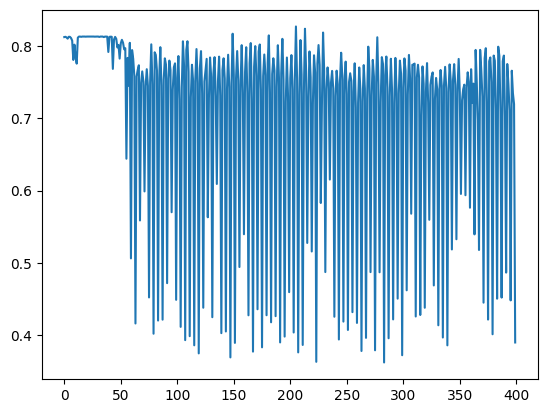

In [6]:
loss_history_tmp = [i if i < 5 else 5 for i in loss_history]
plt.plot(loss_history_tmp)
plt.show()

In [7]:
labels = []
embeddings = []
model.eval()
for sample in list(iter(sampler))[:50]:
    new_x = torch.empty(0, 30*1024).cuda()
    for emb in sample["x"]: 
        emb = emb.cuda()
        emb = emb[emb.isnan()==False]
        n_to_add = 30 - emb.shape[0] // 1024
        while n_to_add > 0:
            emb = torch.cat((emb, emb), dim=0)
            n_to_add = 30 - emb.shape[0] // 1024
        emb = emb[:30*1024]
        new_x = torch.vstack((new_x, emb))
    out = model(x=new_x, edge_index=sample["edge_index"].cuda())
    embeddings.append(out.detach().cpu())
    labels.append(sample["y"].tolist())

In [9]:
from umap import UMAP
reduced_embeddings = UMAP(n_neighbors=20).fit_transform(torch.cat(embeddings, dim=0))
reduced_embeddings.shape

(656, 2)

In [10]:
labels = [i for j in labels for i in j]

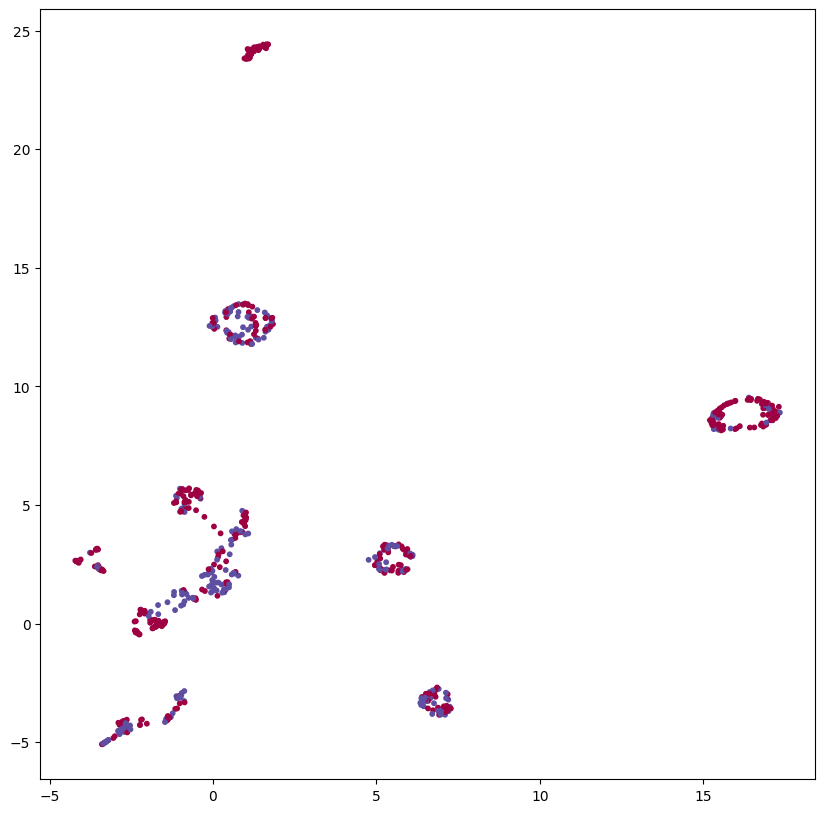

In [12]:
# Plot embeddings and color by labels
plt.figure(figsize=(10, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap="Spectral", s=10)
plt.show()